In [1]:
import numpy as np
import lysis
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap

from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

In [2]:
e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code="2023-01-24-0100")
e.read_file()
file_code = "_PLG2_tPA01_Kd00020036_into_Q2.dat"

In [3]:
print(e)

experiment_code : 2023-01-24-0100
data_filenames  : unbinding_time    : tsectPA.dat
                  lysis_time        : lysismat.dat
                  total_lyses       : lenlysisvect.dat
                  degradation_state : deg.dat
micro_params    : None
macro_params    : binding_rate       : 0.1
                  pore_size          : 0.00010135
                  diffusion_coeff    : 5e-07
                  binding_sites      : 427
                  forced_unbind      : 0.5143
                  average_bind_time  : 27.8
                  grid_node_distance : 1.0862
                  cols               : 93
                  rows               : 121
                  full_row           : 278
                  xz_row             : 185
                  total_edges        : 33,545
                  total_fibers       : 25,761
                  empty_rows         : 28
                  last_empty_edge    : 7,783
                  total_molecules    : 43,074
                  moving_pro

In [4]:
deg = np.fromfile(os.path.join(e.os_path, "deg" + file_code))
tsave = np.fromfile(os.path.join(e.os_path, "tsave" + file_code))

In [12]:
tsave

array([[  0.        ,   1.00013312,  11.00009472,  21.00005631,
         31.00001791,  41.0003219 ,  51.0002835 ,  61.0002451 ,
         71.0002067 ,  81.00016829,  91.00012989, 101.00009149,
        111.00005309, 121.00001469, 131.00031868, 141.00028028,
        151.00024187, 161.00020347, 171.00016507, 181.00012667,
        191.00008826, 201.00004986, 211.00001146, 221.00031545,
        231.00027705, 241.00023865, 251.00020025, 261.00016184,
        271.00012344, 281.00008504, 291.00004664, 301.00000823,
        311.00031223, 321.00027382, 331.00023542, 341.00019702,
        351.00015862, 361.00012022, 371.00008181, 381.00004341,
        391.00000501, 401.000309  , 411.0002706 , 421.0002322 ,
        431.00019379, 441.00015539, 451.00011699, 461.00007859,
        471.00004019, 481.00000178, 491.00030578, 501.00026737,
        511.00022897, 521.00019057, 531.00015217, 541.00011376,
        551.00007536, 561.00003696, 571.00034095, 581.00030255,
        591.00026415, 601.00022575, 611.

In [5]:
deg = deg.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_edges)

In [6]:
tsave = tsave.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves)

In [7]:
mapped_deg = deg
#mapped_deg[:,:,e.macro_params.last_empty_edge+1:][deg[:,:,e.macro_params.last_empty_edge+1:] == 0] = e.macro_params.total_time * 10
mapped_deg = -deg
mapped_deg[deg == 0] = e.macro_params.total_time * 2
mapped_deg[deg == -1] = 0
#for i in range(e.macro_params.total_edges):
#    mapped_deg[:, :, i] -= tsave

In [8]:
def plot_coords(i, j):
    x = j
    y = i
    if j % 3 == 0:
        return x / 3.0, y + 0.5
    if j % 3 == 1:
        return (x - 1) / 3.0, y
    if j % 3 == 2:
        return (x - 2) / 3.0 + 0.5, y

In [9]:
x = np.empty(e.macro_params.total_edges, dtype=float)
y = np.empty(e.macro_params.total_edges, dtype=float)
for k in range(e.macro_params.total_edges):
    i, j = lysis.from_fortran_edge_index(k, e.macro_params.rows, e.macro_params.cols)
    x[k], y[k] = plot_coords(i, j)

In [10]:
colormap = plt.cm.viridis(np.arange(plt.cm.viridis.N))
colormap[:,3] = 0.75
colormap = ListedColormap(colormap)

#colormap = mpl.colormaps['viridis']
#colormap[:,0:3] *= 0.5
colormap.set_extremes(bad='k', under='w', over='k')

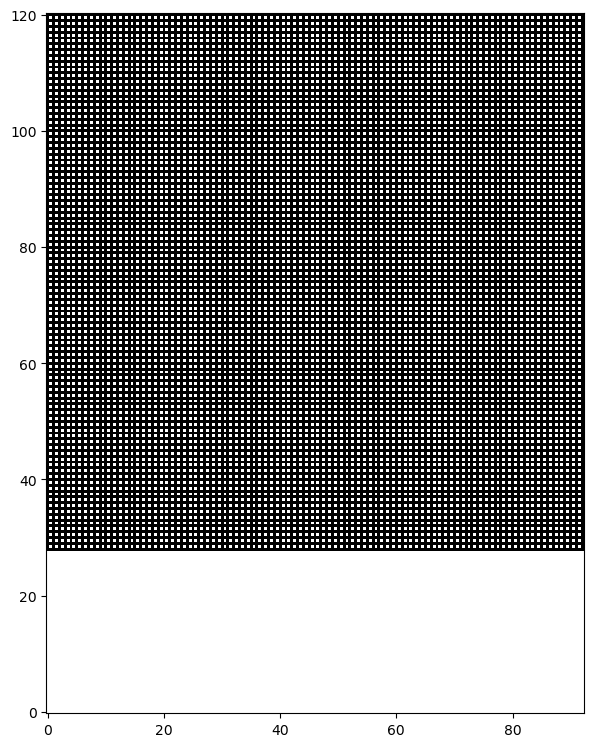

In [11]:
run = 0

plt.ioff()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1])#, frameon=False)
vmin = 0
vmax = e.macro_params.cols - 1

ydiff = e.macro_params.rows - e.macro_params.cols

ax.set_xlim(vmin - 0.25, vmax + 0.25)
ax.set_ylim(vmin - 0.25, vmax + ydiff + 0.25)
ax.set_aspect('equal')
fig.canvas.draw()
s = ((ax.get_window_extent().width  / (vmax-vmin+0.5) * 72/(2*fig.dpi)) ** 2)
scatt = ax.scatter(x, y, 
                   s=s, marker='s', linewidths=0,
                   c=mapped_deg[run, 0], cmap=colormap,
                   #vmin = 0, vmax=e.macro_params.total_time,
                   plotnonfinite=True,
                   vmin=1, vmax=mapped_deg[run, e.macro_params.number_of_saves-1][mapped_deg[run, e.macro_params.number_of_saves-1] < e.macro_params.total_time].max())

def update(frame_number):
    scatt.set_array(mapped_deg[run, frame_number])
    
animation = FuncAnimation(fig, update, frames=np.arange(e.macro_params.number_of_saves), interval=200)

#HTML(animation.to_jshtml())
HTML(animation.to_html5_video())